# MammoScan AI: 01 - Initial Data Exploration

## 🎯 Goal
The objective of this notebook is to perform an initial Exploratory Data Analysis (EDA) on the "Mammogram Mastery" dataset. We aim to understand the structure, content, and quality of our data before proceeding to the modeling phase.

Our key questions are:
1.  How is the dataset structured?
2.  What is the distribution of classes (Cancer vs. Non-Cancer)? Is it balanced?
3.  What are the properties of the images (dimensions, color channels)?
4.  Are there any visible differences between the classes?

## ⚙️ Setup

First, we'll import the necessary libraries for data manipulation, visualization, and image processing. We also need to configure our system path to ensure the notebook can find our custom utility functions located in the `ml/src` directory.

In [2]:
# --- Core Libraries ---
import os
import sys
import pandas as pd
import numpy as np
import cv2  # OpenCV for image processing

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Path Setup ---
# Add the project's root directory to the Python path
# This allows us to import our custom modules from 'ml/src'
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Custom Modules ---
from ml.src.data_utils import load_image_paths

# --- Notebook Settings ---
sns.set_style('whitegrid')
%matplotlib inline

## 📥 Data Loading

Our dataset is versioned using DVC and stored in Google Cloud Storage. The first step is to ensure the data is present locally by running `dvc pull`.

Next, we will use our custom `load_image_paths` function from `ml/src/data_utils.py`. This keeps our notebook clean and ensures our data loading logic is reusable. The function scans the `data/raw` directory and returns a structured pandas DataFrame containing the file path and corresponding label for every image.

In [3]:
# Ensure the data is pulled from our GCS remote storage
# !dvc pull

In [4]:
# Define the path to our raw data directory
DATA_DIR = os.path.join(project_root, 'data', 'raw')

# Load the data using our reusable utility function
df = load_image_paths(DATA_DIR)

print(f"Successfully loaded {len(df)} image paths.")
df.head()

Successfully loaded 10430 image paths.


,filepath,label
0,/home/mr-rey/Joseph/Projects/Python/mammoscan-...,Cancer
1,/home/mr-rey/Joseph/Projects/Python/mammoscan-...,Cancer
2,/home/mr-rey/Joseph/Projects/Python/mammoscan-...,Cancer
3,/home/mr-rey/Joseph/Projects/Python/mammoscan-...,Cancer
4,/home/mr-rey/Joseph/Projects/Python/mammoscan-...,Cancer


## 📊 Analysis 1: Class Distribution

A critical first step in any classification problem is to understand the class balance. An imbalanced dataset, where one class has significantly more samples than another, can bias the model during training. We need to check if we have a roughly equal number of 'Cancer' and 'Non-Cancer' images.

In [7]:
# Let's see the counts for each label
class_counts = df['label'].value_counts()
print("Class Distribution:")
print(class_counts)

Class Distribution:
label
Non-Cancer    8680
Cancer        1750
Name: count, dtype: int64


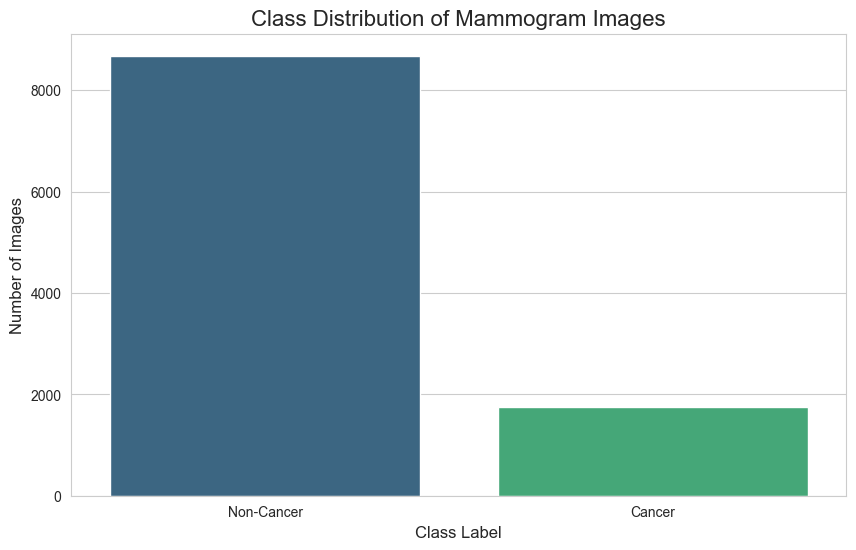

In [10]:
# Visualize the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values,
    hue=class_counts.index,     # explicitly map colors to categories
    palette='viridis',
    legend=False                # remove redundant legend
)
plt.title('Class Distribution of Mammogram Images', fontsize=16)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=0)
plt.show()


> #### 📝 Observation
> The dataset is **highly imbalanced**.  
> We have **8,680 _Non-Cancer_** images but only **1,750 _Cancer_** images.  
> The _Non-Cancer_ class is almost **5× larger** than the _Cancer_ class.
>
> If we train a model on this data as-is, it will likely become very good at predicting **Non-Cancer** simply because it dominates the dataset.  
> This may result in **high accuracy** but **poor detection of the rare (and more critical) _Cancer_ cases**.
>
> To address this, we need **class imbalance handling techniques** such as:
>
> - **Class Weighting** → Tell the model to pay more attention to the _Cancer_ class.  
> - **Oversampling** → Create more copies of the _Cancer_ samples.  
> - **Undersampling** → Reduce the number of _Non-Cancer_ samples.  


## 🖼️ Analysis 2: Image Properties

Deep learning models, especially CNNs, require images to have a consistent size and number of channels. We need to investigate a sample image to determine its properties. This will inform our preprocessing steps later.

Sample Image Path: /home/mr-rey/Joseph/Projects/Python/mammoscan-AI/data/raw/Augmented Dataset/Cancer/IMG (94)_Crop.jpg
Sample Image Label: Cancer
Image Dimensions (H, W, C): (1080, 1920, 3)


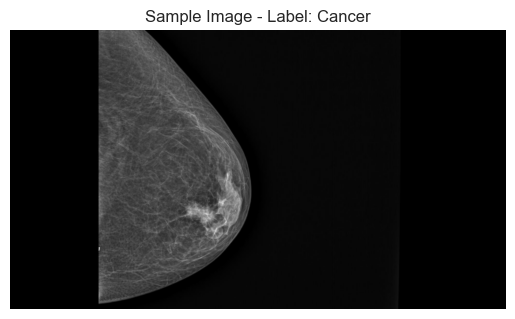

In [11]:
# Load a sample image to inspect its properties
sample_image_path = df['filepath'].iloc[0]
sample_image = cv2.imread(sample_image_path)
sample_label = df['label'].iloc[0]

# Check the dimensions (Height, Width, Channels)
image_shape = sample_image.shape

print(f"Sample Image Path: {sample_image_path}")
print(f"Sample Image Label: {sample_label}")
print(f"Image Dimensions (H, W, C): {image_shape}")

# Display the sample image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title(f"Sample Image - Label: {sample_label}")
plt.axis('off')
plt.show()

> #### 📝 Observation
> The sample image has dimensions **(1080, 1920, 3)**.  
> - **1080 pixels tall**, **1920 pixels wide** → high-resolution image.  
> - **3 channels** → RGB color format.
>
> - **High Resolution** → Training directly on such large images would be **computationally expensive and slow**.  
>   ✅ We must **resize all images** to a smaller, standard square shape (e.g., `224×224` or `299×299`) as part of preprocessing.  
>
> - **Color Channels** → The images are **RGB**.  
>   🔎 We need to decide whether to keep color information or convert to grayscale:  
>   - Grayscale (1 channel) → simpler, less compute.  
>   - RGB (3 channels) → preserves full color info, aligns with most **pre-trained CNNs** (e.g., ResNet, Inception).  
>
> 👉 For now, we’ll **keep RGB** since that’s the expected input format for standard pre-trained models.


## 👀 Analysis 3: Visualizing Image Samples

Finally, let's look at a grid of images from each class. This helps us get a qualitative feel for the data. Are there obvious visual patterns? Do the augmented images look realistic? A visual check is an essential sanity check.

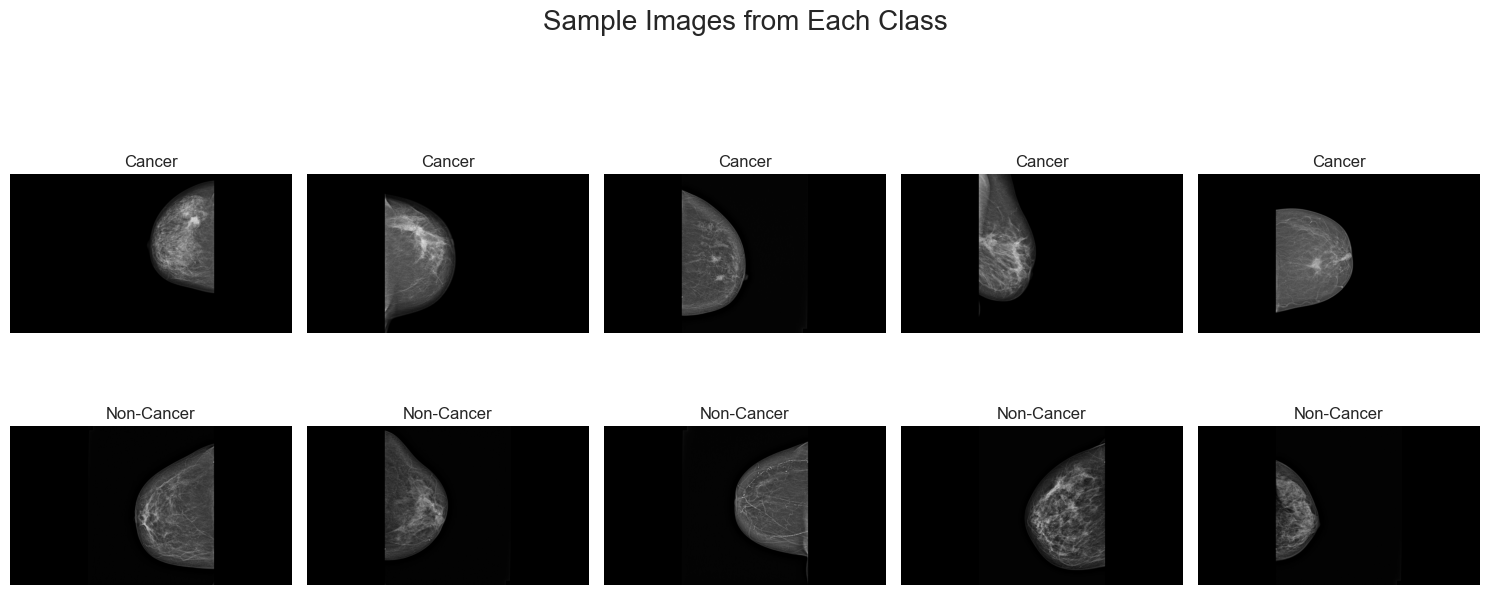

In [12]:
def plot_sample_images(df, n_samples=5):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 7))
    fig.suptitle('Sample Images from Each Class', fontsize=20)

    for i, label in enumerate(['Cancer', 'Non-Cancer']):
        sample_df = df[df['label'] == label].sample(n_samples, random_state=42)
        for j, filepath in enumerate(sample_df['filepath']):
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].set_title(label)
            axes[i, j].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# We only want to visualize samples from the original dataset for a clean comparison
original_df = df[df['filepath'].str.contains('Original')]
plot_sample_images(original_df)

> #### 📝 Observation
> The images are **clean and well-centered**.  
> However, there are **no obvious, simple patterns** that reliably separate *Cancer* from *Non-Cancer* by eye.  
> - *Cancerous tissues* → often appear as **dense, irregular white patches**.  
> - But, **similar dense regions** can also appear in *Non-Cancer* images.
>
> - The task is **not solvable with simple visual rules**.  
> - We require a **sophisticated feature extractor** that can capture subtle differences in texture and shape.  
> - ✅ A **Convolutional Neural Network (CNN)** is well-suited for this job:  
>   - Learns **hierarchical features** (edges → textures → complex patterns).  
>   - Can detect **fine-grained differences** humans cannot easily define.  
>
> 👉 This reinforces the need to move forward with a **deep learning–based approach** rather than manual feature engineering.
